In [3]:
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()

import torch 
def calculate_scaling_factor(clean_audio, noise_audio, target_snr):
    """Calculate the scaling factor to adjust noise to the target SNR level."""
    target_snr = float(target_snr)
    clean_power = torch.mean(clean_audio**2)
    noise_power = torch.mean(noise_audio**2)
    desired_noise_power = clean_power / (10 ** (target_snr / 10))
    scaling_factor = torch.sqrt(desired_noise_power / noise_power)
    return scaling_factor

In [4]:
# import os
# import re
# import shutil
# import random
# from collections import defaultdict
# from pathlib import Path

# def parse_reader_id(filename):
#     """Extract reader ID from filename like: book_0000_chp_009_reader_84372_2.wav"""
#     match = re.search(r"reader_(\d+)_", filename)
#     return match.group(1) if match else None

# def organize_clips_from_flat_dir(src_dir, dest_dir, num_speakers=10, clips_per_speaker=10, seed=42):
#     random.seed(seed)
#     src_dir = Path(src_dir)
#     dest_dir = Path(dest_dir)
#     clean_wav_dir = dest_dir / "clean_wav"
#     clean_train_dir = dest_dir / "clean_train"
#     clean_wav_dir.mkdir(parents=True, exist_ok=True)
#     clean_train_dir.mkdir(parents=True, exist_ok=True)

#     # Step 1: Group files by speaker (reader)
#     speaker_to_files = defaultdict(list)
#     for file in src_dir.glob("*.wav"):
#         reader_id = parse_reader_id(file.name)
#         if reader_id:
#             speaker_to_files[reader_id].append(file)

#     # Step 2: Filter and randomly select speakers
#     eligible_speakers = [s for s, files in speaker_to_files.items() if len(files) >= clips_per_speaker]
#     selected_speakers = random.sample(eligible_speakers, min(num_speakers, len(eligible_speakers)))

#     for reader_id in selected_speakers:
#         files = random.sample(speaker_to_files[reader_id], clips_per_speaker)
#         main_clip = files[0]
#         support_clips = files[1:]

#         # Copy main clip to clean_wav/
#         shutil.copy(main_clip, clean_wav_dir / main_clip.name)

#         # Copy other 9 to clean_train/<main_clip_stem>/
#         support_dir = clean_train_dir / main_clip.stem
#         support_dir.mkdir(parents=True, exist_ok=True)

#         for clip in support_clips:
#             shutil.copy(clip, support_dir / clip.name)

#         print(f"Processed speaker {reader_id}: main={main_clip.name}, train={len(support_clips)} clips")

# # Example usage
# organize_clips_from_flat_dir(
#     src_dir="/data/ephraim/datasets/DNS-Challenge_old/datasets/clean",
#     dest_dir="/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5lib_net2b/"
# )



In [ ]:
import os
import re
import shutil
import random
from collections import defaultdict
from pathlib import Path
import torchaudio

def parse_reader_id(filename):
    match = re.search(r"reader_(\d+)_", filename)
    return match.group(1) if match else None

def organize_and_resample_clips(src_dir, dest_dir, num_speakers=10, clips_per_speaker=10, seed=42, target_sr=16000):
    random.seed(seed)
    src_dir = Path(src_dir)
    dest_dir = Path(dest_dir)

    original_clean_wav_dir = dest_dir / "original_clean_wav"
    original_clean_train_dir = dest_dir / "original_clean_train"
    clean_wav_dir = dest_dir / "clean_wav"
    clean_train_dir = dest_dir / "clean_train"

    for d in [original_clean_wav_dir, original_clean_train_dir, clean_wav_dir, clean_train_dir]:
        d.mkdir(parents=True, exist_ok=True)

    speaker_to_files = defaultdict(list)
    for file in src_dir.glob("*.wav"):
        reader_id = parse_reader_id(file.name)
        if reader_id:
            speaker_to_files[reader_id].append(file)

    eligible_speakers = [s for s, files in speaker_to_files.items() if len(files) >= clips_per_speaker]
    selected_speakers = random.sample(eligible_speakers, min(num_speakers, len(eligible_speakers)))

    for idx, reader_id in enumerate(selected_speakers):
        files = random.sample(speaker_to_files[reader_id], clips_per_speaker)
        main_clip = files[0]
        support_clips = files[1:]
        file_id = f"fileid_{idx}"

        # Original
        shutil.copy(main_clip, original_clean_wav_dir / main_clip.name)
        orig_train_dir = original_clean_train_dir / file_id
        orig_train_dir.mkdir(parents=True, exist_ok=True)
        for clip in support_clips:
            shutil.copy(clip, orig_train_dir / clip.name)

        # Resampled
        waveform, sr = torchaudio.load(main_clip)
        if sr != target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, target_sr)
        torchaudio.save(clean_wav_dir / f"{main_clip.stem}_{file_id}.wav", waveform, target_sr,encoding="PCM_F")

        resampled_dir = clean_train_dir / file_id
        resampled_dir.mkdir(parents=True, exist_ok=True)
        for clip in support_clips:
            waveform, sr = torchaudio.load(clip)
            if sr != target_sr:
                waveform = torchaudio.functional.resample(waveform, sr, target_sr)
            torchaudio.save(resampled_dir / clip.name, waveform, target_sr,encoding="PCM_F")

        print(f"Saved: speaker {reader_id} as {file_id}")

# Example:
src_dir="/data/ephraim/datasets/DNS-Challenge_old/datasets/clean"
dest_dir="/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b/"
organize_and_resample_clips(src_dir, dest_dir, num_speakers=10, clips_per_speaker=10)
    

Saved: speaker 03714 as fileid_0
Saved: speaker 09440 as fileid_1
Saved: speaker 11377 as fileid_2
Saved: speaker 04199 as fileid_3
Saved: speaker 11207 as fileid_4
Saved: speaker 06475 as fileid_5
Saved: speaker 04433 as fileid_6
Saved: speaker 00123 as fileid_7
Saved: speaker 06271 as fileid_8
Saved: speaker 04278 as fileid_9


In [2]:
import shutil
from pathlib import Path

def copy_directory(src_dir, dest_dir, overwrite=False):
    """
    Copy a directory and all its contents from src_dir to dest_dir.

    Parameters:
    - src_dir (str or Path): Source directory path
    - dest_dir (str or Path): Destination directory path
    - overwrite (bool): If True, will overwrite the destination if it exists
    """
    src_dir = Path(src_dir)
    dest_dir = Path(dest_dir)

    if not src_dir.exists():
        raise FileNotFoundError(f"Source directory '{src_dir}' does not exist.")

    if dest_dir.exists():
        if overwrite:
            shutil.rmtree(dest_dir)
        else:
            raise FileExistsError(f"Destination '{dest_dir}' already exists. Use overwrite=True to replace it.")

    shutil.copytree(src_dir, dest_dir)
    print(f"Copied '{src_dir}' → '{dest_dir}'")

# Example usage:


In [ ]:
copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librW_net3_6/", overwrite=False)
copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net3_6/", overwrite=False)

In [9]:
import torch
import torchaudio
import os
from pathlib import Path

def generate_white_noise(length, amplitude=1.0):
    return amplitude * torch.randn(1, length)

def calculate_scaling_factor(clean_audio, noise_audio, target_snr):
    """Calculate the scaling factor to adjust noise to the target SNR level."""
    target_snr = float(target_snr)
    clean_power = torch.mean(clean_audio**2)
    noise_power = torch.mean(noise_audio**2)
    desired_noise_power = clean_power / (10 ** (target_snr / 10))
    scaling_factor = torch.sqrt(desired_noise_power / noise_power)
    return scaling_factor

def generate_and_mix_noise_with_snr(dest_dir, num_noises=10, sr=16000, target_snr=5.0):
    dest_dir = Path(dest_dir)
    noise_dir = dest_dir / "noises"
    clean_wav_dir = dest_dir / "clean_wav"
    noisy_wav_dir = dest_dir / "noisy_wav"

    noise_dir.mkdir(parents=True, exist_ok=True)
    noisy_wav_dir.mkdir(parents=True, exist_ok=True)

    # Load clean wavs
    clean_files = sorted(list(clean_wav_dir.glob("*.wav")))

    print("Generating noise and saving noisy files with SNR...")
    for i, clean_path in enumerate(clean_files[:num_noises]):
        clean_audio, sr = torchaudio.load(clean_path)
        noise = generate_white_noise(clean_audio.shape[-1])

        scaling_factor = calculate_scaling_factor(clean_audio, noise, target_snr)
        noise_scaled = noise * scaling_factor

        # Save raw noise
        noise_path = noise_dir / f"noise_fileid_{i}.wav"
        torchaudio.save(noise_path, noise_scaled, sr,encoding="PCM_F")

        # Add noise to clean and save noisy wav
        noisy = clean_audio + noise_scaled
        noisy_path = noisy_wav_dir / clean_path.name
        torchaudio.save(noisy_path, noisy, sr,encoding="PCM_F")

        print(f"Processed {clean_path.name} with SNR={target_snr:.1f} dB")

# Example usage
generate_and_mix_noise_with_snr("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librW_net3_6/", num_noises=10, target_snr=5.0)

Generating noise and saving noisy files with SNR...
Processed book_01436_chp_0016_reader_04278_27_fileid_9.wav with SNR=5.0 dB
Processed book_01652_chp_0035_reader_09440_1_fileid_1.wav with SNR=5.0 dB
Processed book_02132_chp_0098_reader_00123_7_fileid_7.wav with SNR=5.0 dB
Processed book_03171_chp_0011_reader_04433_30_fileid_6.wav with SNR=5.0 dB
Processed book_03465_chp_0008_reader_06475_7_fileid_5.wav with SNR=5.0 dB
Processed book_03855_chp_0003_reader_11207_1_fileid_4.wav with SNR=5.0 dB
Processed book_06222_chp_0018_reader_11377_10_fileid_2.wav with SNR=5.0 dB
Processed book_09293_chp_0013_reader_03714_9_fileid_0.wav with SNR=5.0 dB
Processed book_11020_chp_0008_reader_06271_24_fileid_8.wav with SNR=5.0 dB
Processed book_11099_chp_0020_reader_04199_14_fileid_3.wav with SNR=5.0 dB


Copied '/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5lib_net2b' → '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net2b'


In [3]:
import torch
import torchaudio
import numpy as np
import os
from pathlib import Path


import numpy as np
import torch
from scipy.signal import lfilter

def generate_stable_ar_coeffs(order, max_abs=0.95, seed=None):
    """
    Generate stable AR coefficients by placing poles inside unit circle.
    """
    if seed is not None:
        np.random.seed(seed)

    # Random poles (inside unit circle)
    poles = np.random.uniform(-max_abs, max_abs, order)
    # Convert to AR coefficients via polynomial expansion
    # For AR: a(z) = 1 - a1*z^-1 - a2*z^-2 - ... ⇒ use np.poly to get that
    ar_coefs = np.poly(poles)[1:]  # drop leading 1
    return ar_coefs

def calculate_scaling_factor(clean_audio, noise_audio, target_snr):
    """Calculate the scaling factor to adjust noise to the target SNR level."""
    target_snr = float(target_snr)
    clean_power = torch.mean(clean_audio**2)
    noise_power = torch.mean(noise_audio**2)
    desired_noise_power = clean_power / (10 ** (target_snr / 10))
    scaling_factor = torch.sqrt(desired_noise_power / noise_power)
    return scaling_factor

def create_ar_noise(n_samples, ar_coefs, sigma=1.0, dtype=torch.float32):
    """
    Create stable AR noise using lfilter.
    """
    # AR: y[n] + a1*y[n-1] + ... = x[n] ⇒ lfilter([1], [1, -a1, -a2, ...], x)
    white_noise = np.random.normal(scale=sigma, size=n_samples)
    a = np.concatenate(([1.0], -ar_coefs))  # [1, -a1, -a2, ...]
    ar_noise = lfilter([1], a, white_noise)

    ar_noise -= np.mean(ar_noise)
    ar_noise /= np.std(ar_noise) + 1e-8  # normalize
    return torch.tensor(ar_noise, dtype=dtype).unsqueeze(0)  # shape (1, L)


def generate_and_mix_ar_noise(dest_dir, num_noises=10, sr=16000, target_snr=5.0):
    dest_dir = Path(dest_dir)
    noise_dir = dest_dir / "noises"
    clean_wav_dir = dest_dir / "clean_wav"
    noisy_wav_dir = dest_dir / "noisy_wav"

    noise_dir.mkdir(parents=True, exist_ok=True)
    noisy_wav_dir.mkdir(parents=True, exist_ok=True)

    clean_files = sorted(list(clean_wav_dir.glob("*.wav")))

    # Example AR configuration (stable low coefficients)
    ar_order = 10
    ar_coefs = np.array([0.1] * ar_order)

    print("Generating AR noise and saving noisy files with SNR...")
    for i, clean_path in enumerate(clean_files[:num_noises]):
        clean_audio, sr = torchaudio.load(clean_path)
        
        ar_coefs = generate_stable_ar_coeffs(order=ar_order, max_abs=0.8, seed=42+i)

        # noise = create_ar_noise(clean_audio.shape[-1], ar_coefs, order=ar_order)
        noise = create_ar_noise(clean_audio.shape[-1], ar_coefs)

        scaling_factor = calculate_scaling_factor(clean_audio, noise, target_snr)
        noise_scaled = noise * scaling_factor

        # Save raw noise
        noise_path = noise_dir / f"noise_fileid_{i}.wav"
        torchaudio.save(noise_path, noise_scaled, sr)

        # Add noise to clean and save noisy file
        noisy = clean_audio + noise_scaled
        noisy_path = noisy_wav_dir / clean_path.name
        torchaudio.save(noisy_path, noisy, sr)

        print(f"Processed {clean_path.name} with AR noise (order={ar_order}) | SNR={target_snr:.1f} dB")

# Example usage:
generate_and_mix_ar_noise("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net3_6", num_noises=10, target_snr=5.0)

Generating AR noise and saving noisy files with SNR...
Processed book_01436_chp_0016_reader_04278_27_fileid_9.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_01652_chp_0035_reader_09440_1_fileid_1.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_02132_chp_0098_reader_00123_7_fileid_7.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_03171_chp_0011_reader_04433_30_fileid_6.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_03465_chp_0008_reader_06475_7_fileid_5.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_03855_chp_0003_reader_11207_1_fileid_4.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_06222_chp_0018_reader_11377_10_fileid_2.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_09293_chp_0013_reader_03714_9_fileid_0.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_11020_chp_0008_reader_06271_24_fileid_8.wav with AR noise (order=10) | SNR=5.0 dB
Processed book_11099_chp_0020_reader_04199_14_fileid_3.wav with AR noise (ord

In [10]:
import torch, torchaudio, random, numpy as np
from pathlib import Path

# ---------- utility ----------------------------------------------------------
def calculate_scaling_factor(clean, noise, target_snr):
    target_snr = float(target_snr)
    clean_pow = torch.mean(clean**2)
    noise_pow = torch.mean(noise**2)
    desired_noise_pow = clean_pow / (10**(target_snr / 10))
    return torch.sqrt(desired_noise_pow / noise_pow)

def create_ar_noise(n_samples, ar_coefs, dtype=torch.float32):
    order = len(ar_coefs)
    white = np.random.normal(0, 1, n_samples + order)
    ar_noise = np.zeros_like(white)
    for i in range(order, n_samples + order):
        ar_noise[i] = np.dot(ar_coefs, ar_noise[i - order:i]) + white[i]
    return torch.from_numpy(ar_noise[order:]).to(dtype).view(1, -1)

# ---------- coefficient templates -------------------------------------------
BASE_COEFS = [
    [ 0.9],
    [ 0.6, -0.1, 0.2],
    [-0.9],
    [ 0.4, -0.1, 0.1, -0.05, 0.03],
    [ 0.4,-0.1,0.1,-0.05,0.03,-0.01,0.06,-0.05,0.003,0.09,
      0.01,0.03,-0.05,0.02,-0.01,0.03,-0.005,0.009,-0.05,0.03]
]

def jitter_ar_coefs(base, sigma=0.02):
    """Return a slightly-perturbed copy, clipped to ±0.95."""
    perturbed = np.clip(np.array(base) + np.random.normal(0, sigma, len(base)),
                        -0.95, 0.95)
    return perturbed

# ---------- main routine -----------------------------------------------------
def generate_ar_noisy_set(dest_dir,
                          num_noises=10,
                          target_snr=5.0,
                          sr=16000,
                          seed=123):
    random.seed(seed)
    np.random.seed(seed)
    dest = Path(dest_dir)
    noise_dir = dest / "noises"
    clean_dir = dest / "clean_wav"
    noisy_dir = dest / "noisy_wav"
    for d in (noise_dir, noisy_dir):
        d.mkdir(parents=True, exist_ok=True)

    clean_files = sorted(clean_dir.glob("*.wav"))[:num_noises]
    if len(clean_files) < num_noises:
        print(f"Warning: only {len(clean_files)} clean files found.")

    for idx, clean_path in enumerate(clean_files):
        clean, sr = torchaudio.load(clean_path)

        # choose a base AR template and apply tiny jitter
        base = random.choice(BASE_COEFS)
        ar_coefs = jitter_ar_coefs(base, sigma=0.02)

        noise = create_ar_noise(clean.shape[-1], ar_coefs)

        # scale noise to desired SNR
        factor = calculate_scaling_factor(clean, noise, target_snr)
        noise_scaled = noise * factor

        # save noise
        noise_path = noise_dir / f"noise_fileid_{idx}.wav"
        torchaudio.save(noise_path, noise_scaled, sr)

        # add to clean and save noisy
        noisy = clean + noise_scaled
        torchaudio.save(noisy_dir / clean_path.name, noisy, sr)

        print(f"[{idx}] {clean_path.name}  |  AR order={len(ar_coefs)}  "
              f"SNR={target_snr} dB  → noisy_wav/{clean_path.name}")

# Example call
# generate_ar_noisy_set("/your/path/to/dest", num_noises=10, target_snr=5.0)
# Example usage
generate_ar_noisy_set("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net3_6", num_noises=10, target_snr=5.0)

[0] book_01436_chp_0016_reader_04278_27_fileid_9.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_01436_chp_0016_reader_04278_27_fileid_9.wav
[1] book_01652_chp_0035_reader_09440_1_fileid_1.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_01652_chp_0035_reader_09440_1_fileid_1.wav
[2] book_02132_chp_0098_reader_00123_7_fileid_7.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_02132_chp_0098_reader_00123_7_fileid_7.wav
[3] book_03171_chp_0011_reader_04433_30_fileid_6.wav  |  AR order=5  SNR=5.0 dB  → noisy_wav/book_03171_chp_0011_reader_04433_30_fileid_6.wav
[4] book_03465_chp_0008_reader_06475_7_fileid_5.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_03465_chp_0008_reader_06475_7_fileid_5.wav
[5] book_03855_chp_0003_reader_11207_1_fileid_4.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_03855_chp_0003_reader_11207_1_fileid_4.wav
[6] book_06222_chp_0018_reader_11377_10_fileid_2.wav  |  AR order=1  SNR=5.0 dB  → noisy_wav/book_06222_chp_0018_reader_11377_10_fileid_2.wav
[7] book_09293

In [8]:
import os
from pathlib import Path

def insert_snr_tag_in_filenames(directory, tag="snr5"):
    """
    Insert '_snr5' before '_fileid_' in all .wav filenames within `directory`.
    """
    directory = Path(directory)
    for wav_file in directory.glob("*.wav"):
        old_name = wav_file.name
        if "_fileid_" in old_name:
            parts = old_name.split("_fileid_")
            new_name = f"{parts[0]}_{tag}_fileid_{parts[1]}"
            new_path = wav_file.with_name(new_name)
            os.rename(wav_file, new_path)
            print(f"Renamed: {old_name} → {new_name}")
        else:
            print(f"Skipped (no _fileid_): {old_name}")

# Example usage:


In [ ]:
insert_snr_tag_in_filenames("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librW_net3_6/noisy_wav")

In [2]:
insert_snr_tag_in_filenames("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net3_6/noisy_wav", tag="snr5")

Renamed: book_01436_chp_0016_reader_04278_27_fileid_9.wav → book_01436_chp_0016_reader_04278_27_snr5_fileid_9.wav
Renamed: book_01652_chp_0035_reader_09440_1_fileid_1.wav → book_01652_chp_0035_reader_09440_1_snr5_fileid_1.wav
Renamed: book_02132_chp_0098_reader_00123_7_fileid_7.wav → book_02132_chp_0098_reader_00123_7_snr5_fileid_7.wav
Renamed: book_03171_chp_0011_reader_04433_30_fileid_6.wav → book_03171_chp_0011_reader_04433_30_snr5_fileid_6.wav
Renamed: book_03465_chp_0008_reader_06475_7_fileid_5.wav → book_03465_chp_0008_reader_06475_7_snr5_fileid_5.wav
Renamed: book_03855_chp_0003_reader_11207_1_fileid_4.wav → book_03855_chp_0003_reader_11207_1_snr5_fileid_4.wav
Renamed: book_06222_chp_0018_reader_11377_10_fileid_2.wav → book_06222_chp_0018_reader_11377_10_snr5_fileid_2.wav
Renamed: book_09293_chp_0013_reader_03714_9_fileid_0.wav → book_09293_chp_0013_reader_03714_9_snr5_fileid_0.wav
Renamed: book_11020_chp_0008_reader_06271_24_fileid_8.wav → book_11020_chp_0008_reader_06271_24_sn

In [3]:
for i in range(10):
    insert_snr_tag_in_filenames(f"/data/ephraim/datasets/known_noise/undiff_exps2/exp_librAR_net3_6/{i}/noisy_wav", tag="snr5")

Renamed: noise0_book_09293_chp_0013_reader_03714_9_fileid_0.wav → noise0_book_09293_chp_0013_reader_03714_9_snr5_fileid_0.wav
Renamed: noise1_book_01652_chp_0035_reader_09440_1_fileid_1.wav → noise1_book_01652_chp_0035_reader_09440_1_snr5_fileid_1.wav
Renamed: noise2_book_06222_chp_0018_reader_11377_10_fileid_2.wav → noise2_book_06222_chp_0018_reader_11377_10_snr5_fileid_2.wav
Renamed: noise3_book_11099_chp_0020_reader_04199_14_fileid_3.wav → noise3_book_11099_chp_0020_reader_04199_14_snr5_fileid_3.wav
Renamed: noise4_book_03855_chp_0003_reader_11207_1_fileid_4.wav → noise4_book_03855_chp_0003_reader_11207_1_snr5_fileid_4.wav
Renamed: noise5_book_03465_chp_0008_reader_06475_7_fileid_5.wav → noise5_book_03465_chp_0008_reader_06475_7_snr5_fileid_5.wav
Renamed: noise6_book_03171_chp_0011_reader_04433_30_fileid_6.wav → noise6_book_03171_chp_0011_reader_04433_30_snr5_fileid_6.wav
Renamed: noise7_book_02132_chp_0098_reader_00123_7_fileid_7.wav → noise7_book_02132_chp_0098_reader_00123_7_snr5

## real

In [2]:
copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librReal_net3_6/", overwrite=False)

Copied '/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b' → '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librReal_net3_6'


In [3]:
import random, torch, torchaudio, numpy as np
from pathlib import Path

# ---------- utility functions -----------------------------------------------
def calculate_scaling_factor(clean_audio, noise_audio, target_snr):
    """Return factor to scale noise so (clean+noise) will be at target SNR (dB)."""
    target_snr = float(target_snr)
    clean_pow = torch.mean(clean_audio**2)
    noise_pow = torch.mean(noise_audio**2)
    desired_noise_pow = clean_pow / (10 ** (target_snr / 10))
    return torch.sqrt(desired_noise_pow / noise_pow)

def load_eligible_demand_noises(demand_root, categories, min_len_samples):
    """Return list of Path objects for DEMAND noise files in given categories
       whose length (samples) is >= min_len_samples."""
    eligible = []
    demand_root = Path(demand_root)
    # DEMAND layout: <cat>/<scene>/<mic>.wav  (16-bit 48 kHz mono)
    for wav_path in demand_root.rglob("*.wav"):
        top_cat = wav_path.parts[len(demand_root.parts)]  # first directory under root
        if top_cat.upper() in categories:
            info = torchaudio.info(str(wav_path))
            if info.num_frames >= min_len_samples:
                eligible.append((wav_path, info.num_frames, info.sample_rate))
    return eligible

# ---------- main routine -----------------------------------------------------
def add_demand_noise(dest_dir,
                     demand_root,
                     num_pairs=10,
                     target_snr=5.0,
                     seed=123,
                     categories=("PRESTO", "PSTATION", "NFIELD")):
    random.seed(seed)
    dest = Path(dest_dir)
    clean_dir  = dest / "clean_wav"
    noisy_dir  = dest / "noisy_wav"
    noise_dir  = dest / "noises"
    for d in (noisy_dir, noise_dir):
        d.mkdir(parents=True, exist_ok=True)

    clean_files = sorted(clean_dir.glob("*.wav"))[:num_pairs]
    if len(clean_files) < num_pairs:
        print(f"Only {len(clean_files)} clean files found; proceeding with that.")

    # Determine longest clean length to pre-filter DEMAND list once
    max_clean_frames = max(torchaudio.info(str(f)).num_frames for f in clean_files)
    demand_noises = load_eligible_demand_noises(demand_root,
                                                {c.upper() for c in categories},
                                                min_len_samples=max_clean_frames)
    if len(demand_noises) < len(clean_files):
        raise RuntimeError("Not enough eligible DEMAND noise files.")

    selected_noises = random.sample(demand_noises, len(clean_files))

    for idx, (clean_path, (noise_path, n_frames, n_sr)) in enumerate(zip(clean_files, selected_noises)):
        clean, c_sr = torchaudio.load(clean_path)
        if c_sr != n_sr:  # resample noise to clean SR (clean is 16 kHz in our pipeline)
            noise_wav, _ = torchaudio.load(noise_path)
            noise_wav = torchaudio.functional.resample(noise_wav, n_sr, c_sr)
        else:
            noise_wav, _ = torchaudio.load(noise_path)

        # crop a random segment equal to clean length
        num_needed = clean.shape[-1]
        start = random.randint(0, noise_wav.shape[-1] - num_needed)
        noise_seg = noise_wav[:, start:start + num_needed]

        # scale to target SNR
        factor = calculate_scaling_factor(clean, noise_seg, target_snr)
        noise_scaled = noise_seg * factor

        # save noise segment
        noise_out = noise_dir / f"noise_fileid_{idx}.wav"
        torchaudio.save(noise_out, noise_scaled, c_sr)

        # add and save noisy waveform
        noisy = clean + noise_scaled
        torchaudio.save(noisy_dir / clean_path.name, noisy, c_sr)

        print(f"[{idx}] {clean_path.name:<30} + {noise_path.name:<25} "
              f"→ SNR {target_snr} dB")

# Example call
add_demand_noise(
    dest_dir      = "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librReal_net3_6",
    demand_root   = "/data/ephraim/datasets/demand/demand/",
    num_pairs     = 10,
    target_snr    = 5.0)

[0] book_01436_chp_0016_reader_04278_27_fileid_9.wav + ch04.wav                  → SNR 5.0 dB
[1] book_01652_chp_0035_reader_09440_1_fileid_1.wav + ch02.wav                  → SNR 5.0 dB
[2] book_02132_chp_0098_reader_00123_7_fileid_7.wav + ch06.wav                  → SNR 5.0 dB
[3] book_03171_chp_0011_reader_04433_30_fileid_6.wav + ch11.wav                  → SNR 5.0 dB
[4] book_03465_chp_0008_reader_06475_7_fileid_5.wav + ch15.wav                  → SNR 5.0 dB
[5] book_03855_chp_0003_reader_11207_1_fileid_4.wav + ch07.wav                  → SNR 5.0 dB
[6] book_06222_chp_0018_reader_11377_10_fileid_2.wav + ch03.wav                  → SNR 5.0 dB
[7] book_09293_chp_0013_reader_03714_9_fileid_0.wav + ch09.wav                  → SNR 5.0 dB
[8] book_11020_chp_0008_reader_06271_24_fileid_8.wav + ch03.wav                  → SNR 5.0 dB
[9] book_11099_chp_0020_reader_04199_14_fileid_3.wav + ch04.wav                  → SNR 5.0 dB


In [5]:
insert_snr_tag_in_filenames("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librReal_net3_6/noisy_wav", tag="snr5")

Renamed: book_01436_chp_0016_reader_04278_27_fileid_9.wav → book_01436_chp_0016_reader_04278_27_snr5_fileid_9.wav
Renamed: book_01652_chp_0035_reader_09440_1_fileid_1.wav → book_01652_chp_0035_reader_09440_1_snr5_fileid_1.wav
Renamed: book_02132_chp_0098_reader_00123_7_fileid_7.wav → book_02132_chp_0098_reader_00123_7_snr5_fileid_7.wav
Renamed: book_03171_chp_0011_reader_04433_30_fileid_6.wav → book_03171_chp_0011_reader_04433_30_snr5_fileid_6.wav
Renamed: book_03465_chp_0008_reader_06475_7_fileid_5.wav → book_03465_chp_0008_reader_06475_7_snr5_fileid_5.wav
Renamed: book_03855_chp_0003_reader_11207_1_fileid_4.wav → book_03855_chp_0003_reader_11207_1_snr5_fileid_4.wav
Renamed: book_06222_chp_0018_reader_11377_10_fileid_2.wav → book_06222_chp_0018_reader_11377_10_snr5_fileid_2.wav
Renamed: book_09293_chp_0013_reader_03714_9_fileid_0.wav → book_09293_chp_0013_reader_03714_9_snr5_fileid_0.wav
Renamed: book_11020_chp_0008_reader_06271_24_fileid_8.wav → book_11020_chp_0008_reader_06271_24_sn

In [8]:
import pandas as pd

def choose_closest_to_median(excel_path):
    """
    Read an Excel file, extract numeric values from the 'name' column,
    compute the median, and find the value closest to the median.
    If there's a tie, choose the one that occurs most frequently.
    """
    # Read the Excel file into a DataFrame
    df = pd.read_excel(excel_path)

    # Extract the numeric part from the 'name' column (assumes names like "s0.11" or "s.013")
    df['num'] = df['name'].str.extract(r's([\d\.]+)').astype(float)

    # Calculate the median of the extracted numbers
    median_val = df['num'].median()

    # Find all unique values present
    unique_vals = df['num'].unique()

    # Compute absolute distance from each unique value to the median
    distances = abs(unique_vals - median_val)

    # Identify the minimum distance
    min_dist = distances.min()

    # Candidates are unique values that are closest to the median
    candidates = unique_vals[distances == min_dist]

    # If there are multiple candidates, choose the one occurring most frequently
    if len(candidates) > 1:
        counts = df['num'].value_counts()
        chosen = max(candidates, key=lambda x: counts.loc[x])
    else:
        chosen = candidates[0]

    return chosen
# Example usage:
choose_closest_to_median('/data/ephraim/datasets/known_noise/undiff_exps2/exp_librW_net3_6/analysis/ours_all.xlsx')


# # Replace with the path to your Excel file
# excel_path = '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librW_net3_6/analysis/ours_all.xlsx'

# # Read the Excel file into a DataFrame
# df = pd.read_excel(excel_path)

# # Extract the numeric part from the 'name' column (assumes names like "s0.11" or "s.013")
# df['num'] = df['name'].str.extract(r's([\d\.]+)').astype(float)

# # Calculate the median of the extracted numbers
# median_val = df['num'].median()

# # Find all unique values present
# unique_vals = df['num'].unique()

# # Compute absolute distance from each unique value to the median
# distances = abs(unique_vals - median_val)

# # Identify the minimum distance
# min_dist = distances.min()

# # Candidates are unique values that are closest to the median
# candidates = unique_vals[distances == min_dist]

# # If there are multiple candidates, choose the one occurring most frequently
# if len(candidates) > 1:
#     counts = df['num'].value_counts()
#     chosen = max(candidates, key=lambda x: counts.loc[x])
# else:
#     chosen = candidates[0]

# print(f"Median of numbers: {median_val}")
# print(f"Value closest to median (tie-broken by frequency): {chosen}")


0.11

## real 2 - after fix demand loading

In [3]:

copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/", overwrite=False)

Copied '/data/ephraim/datasets/known_noise/undiff_exps2/exp_p5libr_net2b' → '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6'


In [6]:
import random, csv, shutil, torch, torchaudio, numpy as np
from pathlib import Path
from tqdm import tqdm

# -------------------------------------------------------------------------
# constants
# -------------------------------------------------------------------------
CATS       = {"PRESTO", "PSTATION", "NFIELD"}   # DEMAND folders to use
TARGET_SR  = 16_000
TARGET_SNR = 5.0                                # dB
SEED       = 123
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------------------------------------------------------------
# utilities
# -------------------------------------------------------------------------
def calculate_scaling_factor(clean, noise, snr_db):
    clean_p  = torch.mean(clean**2)
    noise_p  = torch.mean(noise**2)
    desired  = clean_p / (10 ** (snr_db / 10))
    return torch.sqrt(desired / noise_p)

def resample_to(wav, old_sr, new_sr=TARGET_SR):
    return torchaudio.functional.resample(wav, old_sr, new_sr) if old_sr != new_sr else wav

def demand_candidates(demand_root):
    """List[(Path, duration_sec, sr_orig)] of DEMAND noise files in requested categories."""
    root = Path(demand_root)
    out  = []
    for wav in root.rglob("*.wav"):
        top = wav.parts[len(root.parts)].upper()
        if top in CATS:
            info = torchaudio.info(str(wav))
            out.append((wav, info.num_frames / info.sample_rate, info.sample_rate))
    return out

# -------------------------------------------------------------------------
# main routine
# -------------------------------------------------------------------------
def mix_clean_with_demand(dest_dir, demand_root, target_snr: float = TARGET_SNR):
    dest          = Path(dest_dir)
    clean_dir     = dest / "clean_wav"
    train_root    = dest / "clean_train"
    noisy_main    = dest / "noisy_wav"
    noisy_train   = dest / "noisy_train"
    noise_main    = dest / "noises"
    noise_train   = dest / "noise_train"
    orig_noise    = dest / "original_noises"
    for d in [noisy_main, noisy_train, noise_main, noise_train, orig_noise]:
        d.mkdir(parents=True, exist_ok=True)

    mapping_rows = []
    mapping_path = dest / "noise_mapping.csv"

    clean_files  = sorted(clean_dir.glob("*.wav"))            # 10 main clips
    demand_list  = demand_candidates(demand_root)
    print(f"Indexed {len(demand_list)} DEMAND files in {CATS}")

    for idx, clean_path in enumerate(clean_files):
        file_id     = f"fileid_{idx}"
        train_dir   = train_root / file_id
        train_clips = sorted(train_dir.glob("*.wav"))
        group_clips = [clean_path] + train_clips               # 10 clips

        # --- load all 10 clean clips (resampled) ---------------------------
        waves, lengths = [], []
        for p in group_clips:
            w, sr = torchaudio.load(p); w = resample_to(w, sr)
            waves.append(w); lengths.append(w.shape[-1])
        max_len = max(lengths)

        # --- choose DEMAND file >= max_len AFTER resampling ---------------
        candidates = []
        for wav_path, dur_sec, sr_orig in demand_list:
            if int(dur_sec * TARGET_SR) >= max_len:
                candidates.append((wav_path, sr_orig))
        if not candidates:
            raise RuntimeError(f"No DEMAND noise ≥ {max_len} frames for {file_id}")

        noise_path, sr_orig = random.choice(candidates)

        # copy original for bookkeeping
        shutil.copy(noise_path, orig_noise / f"noise_{file_id}.wav")

        # load & resample entire noise only once
        noise_full, _ = torchaudio.load(noise_path)
        noise_full    = resample_to(noise_full, sr_orig)

        # ------------------- mix each clip --------------------------------
        for clip_idx, (w, L) in enumerate(zip(waves, lengths)):
            max_start = noise_full.shape[-1] - L
            start_idx = random.randint(0, max_start)
            noise_seg = noise_full[:, start_idx:start_idx + L]

            factor      = calculate_scaling_factor(w, noise_seg, target_snr)
            noise_scaled = noise_seg * factor
            noisy_mix    = w + noise_scaled

            if clip_idx == 0:      # main clip
                noise_seg_path = noise_main / f"noise_{file_id}.wav"
                noisy_path     = noisy_main / clean_path.name
                clean_ref      = clean_path
            else:                  # training clips
                nt_dir = noise_train / file_id; nt_dir.mkdir(exist_ok=True, parents=True)
                nm_dir = noisy_train / file_id; nm_dir.mkdir(exist_ok=True, parents=True)
                clip_name      = train_clips[clip_idx-1].name
                noise_seg_path = nt_dir / clip_name
                noisy_path     = nm_dir / clip_name
                clean_ref      = train_clips[clip_idx-1]

            torchaudio.save(noise_seg_path, noise_scaled, TARGET_SR)
            torchaudio.save(noisy_path, noisy_mix, TARGET_SR)

            mapping_rows.append({
                "clean_file"   : str(clean_ref),
                "noisy_file"   : str(noisy_path),
                "noise_segment": str(noise_seg_path),
                "demand_source": str(noise_path),
                "start_sample" : start_idx,
                "end_sample"   : start_idx + L - 1,
                "snr_db"       : target_snr
            })

        print(f"[{file_id}] mixed with {noise_path.relative_to(demand_root)} (SNR {target_snr} dB)")

    # ---------------- write mapping CSV -----------------------------------
    with open(mapping_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=mapping_rows[0].keys())
        writer.writeheader(); writer.writerows(mapping_rows)
    print(f"\nMapping saved to {mapping_path}")

# -------------------------------------------------------------------------
# Example call
# -------------------------------------------------------------------------
# mix_clean_with_demand(
#     dest_dir    = "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/",
#     demand_root = "/data/ephraim/datasets/demand/demand/",
#     target_snr  = 5.0)


mix_clean_with_demand(
    dest_dir      = "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/",
    demand_root   = "/data/ephraim/datasets/demand/demand/",
    target_snr    = 5.0)

Indexed 48 DEMAND files in {'PSTATION', 'NFIELD', 'PRESTO'}
[fileid_0] mixed with NFIELD/ch04.wav (SNR 5.0 dB)
[fileid_1] mixed with NFIELD/ch11.wav (SNR 5.0 dB)
[fileid_2] mixed with NFIELD/ch01.wav (SNR 5.0 dB)
[fileid_3] mixed with PSTATION/ch05.wav (SNR 5.0 dB)
[fileid_4] mixed with PRESTO/ch10.wav (SNR 5.0 dB)
[fileid_5] mixed with PSTATION/ch11.wav (SNR 5.0 dB)
[fileid_6] mixed with NFIELD/ch13.wav (SNR 5.0 dB)
[fileid_7] mixed with PSTATION/ch09.wav (SNR 5.0 dB)
[fileid_8] mixed with PRESTO/ch14.wav (SNR 5.0 dB)
[fileid_9] mixed with PSTATION/ch01.wav (SNR 5.0 dB)

Mapping saved to /data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/noise_mapping.csv


In [9]:
insert_snr_tag_in_filenames("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/noisy_wav", tag="snr5")

Renamed: book_01436_chp_0016_reader_04278_27_fileid_9.wav → book_01436_chp_0016_reader_04278_27_snr5_fileid_9.wav
Renamed: book_01652_chp_0035_reader_09440_1_fileid_1.wav → book_01652_chp_0035_reader_09440_1_snr5_fileid_1.wav
Renamed: book_02132_chp_0098_reader_00123_7_fileid_7.wav → book_02132_chp_0098_reader_00123_7_snr5_fileid_7.wav
Renamed: book_03171_chp_0011_reader_04433_30_fileid_6.wav → book_03171_chp_0011_reader_04433_30_snr5_fileid_6.wav
Renamed: book_03465_chp_0008_reader_06475_7_fileid_5.wav → book_03465_chp_0008_reader_06475_7_snr5_fileid_5.wav
Renamed: book_03855_chp_0003_reader_11207_1_fileid_4.wav → book_03855_chp_0003_reader_11207_1_snr5_fileid_4.wav
Renamed: book_06222_chp_0018_reader_11377_10_fileid_2.wav → book_06222_chp_0018_reader_11377_10_snr5_fileid_2.wav
Renamed: book_09293_chp_0013_reader_03714_9_fileid_0.wav → book_09293_chp_0013_reader_03714_9_snr5_fileid_0.wav
Renamed: book_11020_chp_0008_reader_06271_24_fileid_8.wav → book_11020_chp_0008_reader_06271_24_sn

In [10]:
copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_p_net3/", overwrite=False)

Copied '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6' → '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_p_net3'


In [11]:
copy_directory("/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6/", "/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6_snr-5/", overwrite=False)

Copied '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6' → '/data/ephraim/datasets/known_noise/undiff_exps2/exp_librDemandSttnr_net3_6_snr-5'


In [9]:
import torch
import torchaudio
noise1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noises/noise_fileid_6.wav"
noise_1, sr = torchaudio.load(noise1)
noise_1.shape
noise2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noises/noise_fileid_18.wav"
noise_2, sr = torchaudio.load(noise2)
noise_2.shape

torch.Size([1, 4699904])

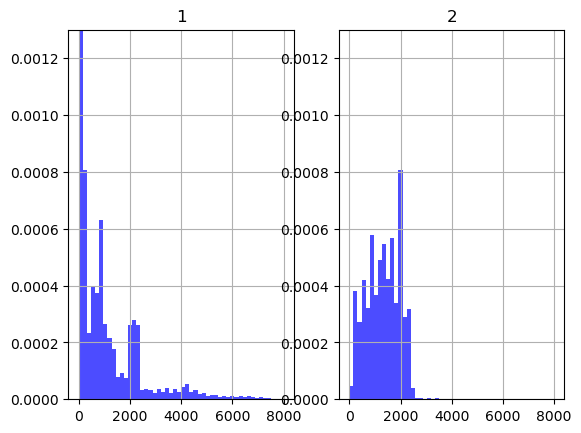

In [10]:
import scipy.signal as signal
from matplotlib import pyplot as plt

freqs1, magnitudes1 = signal.welch(noise_1.squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(noise_2.squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('1')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('2')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)

plt.show()

tensor(0.0036)

In [3]:
import torchaudio.functional as F

In [12]:
noise1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noises/noise_fileid_6.wav"
noise2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noises/noise_fileid_18.wav"
noise_1, sr = torchaudio.load(noise1)
noise_2, sr = torchaudio.load(noise2)

In [13]:
sr

19980

In [81]:
from IPython import display
clean1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/clean_wav/LJ050-0275_fileid_6.wav"
clean_1, sr = torchaudio.load(clean1)
clean_1 = F.resample(clean_1, orig_freq=sr, new_freq=16000)
print(torch.mean(clean_1**2))

clean2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/clean_wav/LJ050-0247_fileid_18.wav"
clean_2, sr = torchaudio.load(clean2)

display.display(display.Audio(clean_2.view(1,-1), rate=sr))
clean_2 = F.resample(clean_2, orig_freq=sr, new_freq=16000)
torch.mean(clean_2**2)

tensor(0.0032)


tensor(0.0041)

In [79]:
sr

22050

In [80]:
display.display(display.Audio(clean_2.view(1,-1), rate=16000))

In [82]:
factor1 =  calculate_scaling_factor(clean_1, noise_1, 5)
factor2 =  calculate_scaling_factor(clean_2, noise_2, 5)
factor1, factor2

(tensor(0.4292), tensor(0.3554))

In [83]:
clean_1.shape[0]

1

In [84]:
noise_1[:clean_1.shape[0], :clean_1.shape[1]]

tensor([[-0.0498, -0.0891, -0.1393,  ...,  0.0186,  0.0029, -0.0386]])

In [85]:
sr=16000

In [ ]:
noisy1path =  "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noisy_wav/LJ050-0275_snr5_fileid_6.wav"
noisy2path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/noisy_wav/LJ050-0247_snr5_fileid_18.wav"
noisy1 = clean_1 + factor1 * noise_1[:clean_1.shape[0], :clean_1.shape[1]]
noisy2 = clean_2 + factor2 * noise_2[:clean_2.shape[0], :clean_2.shape[1]]
torchaudio.save(noisy1path, noisy1, sr)
torchaudio.save(noisy2path, noisy2, sr)

In [87]:
sr

16000

In [5]:
from IPython import display
import torchaudio
import torch
import torchaudio.functional as F
new_freq = 16000
noise1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/noises/noise_fileid_6.wav"
noise2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/noises/noise_fileid_18.wav"
noise_1, sr = torchaudio.load(noise1)
noise_1 = F.resample(noise_1, orig_freq=sr, new_freq=new_freq)
noise_2, sr = torchaudio.load(noise2)
noise_2 = F.resample(noise_2, orig_freq=sr, new_freq=new_freq)
print("sr =", sr)

clean1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/clean_wav/LJ050-0270_fileid_6.wav"
clean_1, sr = torchaudio.load(clean1)
clean_1 = F.resample(clean_1, orig_freq=sr, new_freq=new_freq)
print(torch.mean(clean_1**2))

clean2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/clean_wav/LJ050-0271_fileid_18.wav"
clean_2, sr = torchaudio.load(clean2)
display.display(display.Audio(clean_2.view(1,-1), rate=sr))
clean_2 = F.resample(clean_2, orig_freq=sr, new_freq=new_freq)
torch.mean(clean_2**2)

factor1 =  calculate_scaling_factor(clean_1, noise_1, 5)
factor2 =  calculate_scaling_factor(clean_2, noise_2, 5)
factor1, factor2

noisy1path =  "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/noisy_wav//LJ050-0270_snr5_fileid_6.wav"
noisy2path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o4_net_3_6/noisy_wav/LJ050-0271_snr5_fileid_18.wav"
noisy1 = clean_1 + factor1 * noise_1[:clean_1.shape[0], :clean_1.shape[1]]
noisy2 = clean_2 + factor2 * noise_2[:clean_2.shape[0], :clean_2.shape[1]]
torchaudio.save(noisy1path, noisy1, new_freq)
torchaudio.save(noisy2path, noisy2, new_freq)

sr = 19980
tensor(0.0041)


In [9]:
factor1 =  calculate_scaling_factor(clean_1, noise_1, 5)
factor2 =  calculate_scaling_factor(clean_2, noise_2, 5)
factor1, factor2

NameError: name 'noise_1' is not defined

In [88]:
# wavpath = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o2_net18/clean_wav/p330_372_mic1_fileid_18.wav"
# torchaudio.save(wavpath, clean_2, sr)

In [89]:
mine = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net17/clean_wav/clean_fileid_18.wav"
mine, sr = torchaudio.load(mine)
torch.mean(mine**2)

tensor(0.0012)

In [90]:
aplified = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o_net3_6_amplified_3/6/clean_wav/noise6_book_buccaneer1_snr5_fileid_6.wav"
aplified, sr = torchaudio.load(aplified)
torch.mean(aplified**2)

tensor(0.0118)

(tensor(0.4536), tensor(0.0892))

In [13]:
import torchaudio
import torch
noise1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/noises/noise_fileid_6.wav"
noise2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/noises/noise_fileid_18.wav"
noise_1, sr = torchaudio.load(noise1)
noise_2, sr = torchaudio.load(noise2)


from IPython import display
clean1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/clean_wav/p300_387_mic1.flac"
clean_1, sr = torchaudio.load(clean1)
clean_1 = F.resample(clean_1, orig_freq=sr, new_freq=16000)
print(torch.mean(clean_1**2))

clean2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/clean_wav/p255_260_mic1.flac"
clean_2, sr = torchaudio.load(clean2)

display.display(display.Audio(clean_2.view(1,-1), rate=sr))
clean_2 = F.resample(clean_2, orig_freq=sr, new_freq=16000)
print("clean_2 power:",torch.mean(clean_2**2))

factor1 =  calculate_scaling_factor(clean_1, noise_1, 5)
factor2 =  calculate_scaling_factor(clean_2, noise_2, 5)
factor1, factor2

noisy1path =  "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/noisy_wav/p300_387_mic1_snr5_fileid_6.wav"
noisy2path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/noisy_wav/p255_260_mic1_snr5_fileid_18.wav"
noisy1 = clean_1 + factor1 * noise_1[:clean_1.shape[0], :clean_1.shape[1]]
noisy2 = clean_2 + factor2 * noise_2[:clean_2.shape[0], :clean_2.shape[1]]

sr=16000
torchaudio.save(noisy1path, noisy1, sr)
torchaudio.save(noisy2path, noisy2, sr)

wavpath1 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/clean_wav/p300_387_mic1_fileid_6.wav"
torchaudio.save(wavpath1, clean_1, sr)
wavpath2 = "/data/ephraim/datasets/known_noise/undiff_exps/exp_o3_net16/clean_wav/p255_260_mic1_fileid_18.wav"
torchaudio.save(wavpath2, clean_2, sr)

tensor(0.0024)


clean_2 power: tensor(0.0058)


In [14]:
display.display(display.Audio(clean_1.view(1,-1), rate=16000))

100%|██████████| 111/111 [06:34<00:00,  3.56s/it]


mean, std: 0.002630104328707026 0.0019539812329330366


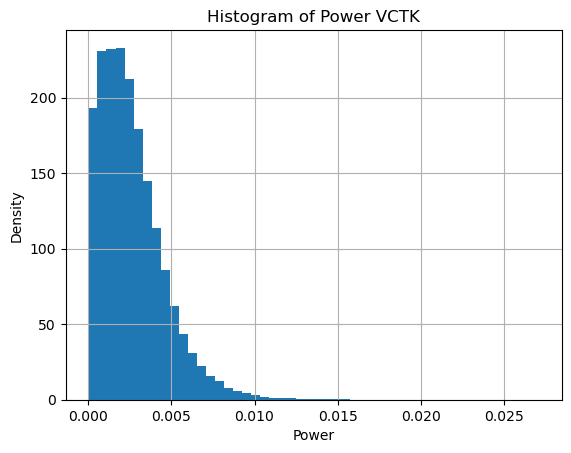

In [34]:
import os
from tqdm import tqdm
vctk = "/data/ephraim/datasets/vctk/VCTK-Corpus-0.92/wav48_silence_trimmed/p376/"
vctk_root = "/data/ephraim/datasets/vctk/VCTK-Corpus-0.92/wav48_silence_trimmed/"
powers = []
for d in tqdm(os.listdir(vctk_root)):
    if os.path.isdir(os.path.join(vctk_root, d)):
        vctk = os.path.join(vctk_root, d)

        files = os.listdir(vctk)

        for f in files:
            if f.endswith(".flac"):
                wav, sr = torchaudio.load(os.path.join(vctk, f))
                powers.append(torch.mean(wav**2).item())

#calc std and mean for the power
import numpy as np
mean = np.mean(powers)
std = np.std(powers)
print("mean, std:",mean, std)
#plot the histogram
plt.hist(powers, bins=50, density=True)
plt.title('Histogram of Power VCTK')
plt.xlabel('Power')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

data = powers # Replace with your data

# Range
data_range = np.max(data) - np.min(data)

# Interquartile Range (IQR)
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Standard Deviation
std_dev = np.std(data)

# Five-Number Summary
five_number_summary = {
    'Minimum': np.min(data),
    'Q1': q1,
    'Median': np.median(data),
    'Q3': q3,
    'Maximum': np.max(data)
}

print(f"Range: {data_range}")
print(f"IQR: {iqr}")
print(f"Standard Deviation: {std_dev}")
print("Five-Number Summary:", five_number_summary)

Range: 0.027148655712153413
IQR: 0.0024473022494930774
Standard Deviation: 0.0019539812329330366
Five-Number Summary: {'Minimum': 9.76860974333249e-07, 'Q1': 0.0011770979908760637, 'Median': 0.0022505606757476926, 'Q3': 0.003624400240369141, 'Maximum': 0.027149632573127747}


In [25]:
# Compute the median
median = np.median(data)

# Compute the median absolute deviation (MAD)
mad = np.median(np.abs(data - median))

# Compute the modified Z-scores
modified_z_scores = 0.6745 * (0.01 - median) / mad

print("Modified Z-scores:", modified_z_scores)

Modified Z-scores: 4.387967648198827


In [23]:
len(powers)

88328

13097
mean, std: 0.004386842364678159 0.0012897568584185693


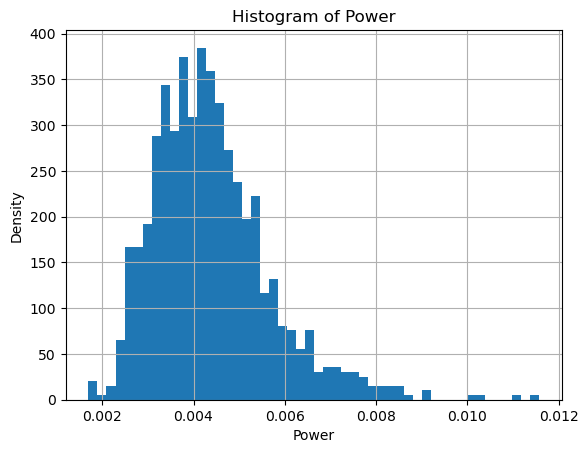

In [29]:
import os
LJSpeech = "/data/ephraim/datasets/LJSpeech-1.1/wavs/"
files = os.listdir(LJSpeech)
print(len(files))
powers2 = []
counter=0
for f in files:
    if f.endswith(".wav"):
        counter+=1
        if counter > 1000:
            break
        wav, sr = torchaudio.load(os.path.join(LJSpeech, f))
        powers2.append(torch.mean(wav**2).item())

#calc std and mean for the power
import numpy as np
mean2 = np.mean(powers2)
std2 = np.std(powers2)
print("mean, std:",mean2, std2)
#plot the histogram
plt.hist(powers2, bins=50, density=True)
plt.title('Histogram of Power')
plt.xlabel('Power')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [30]:
import numpy as np

data = powers2 # Replace with your data

# Range
data_range = np.max(data) - np.min(data)

# Interquartile Range (IQR)
q1 = np.percentile(data, 25)
q3 = np.percentile(data, 75)
iqr = q3 - q1

# Standard Deviation
std_dev = np.std(data)

# Five-Number Summary
five_number_summary = {
    'Minimum': np.min(data),
    'Q1': q1,
    'Median': np.median(data),
    'Q3': q3,
    'Maximum': np.max(data)
}

print(f"Range: {data_range}")
print(f"IQR: {iqr}")
print(f"Standard Deviation: {std_dev}")
print("Five-Number Summary:", five_number_summary)

Range: 0.009877186501398683
IQR: 0.0015572439879179
Standard Deviation: 0.0012897568584185693
Five-Number Summary: {'Minimum': 0.001697855768725276, 'Q1': 0.003475857200101018, 'Median': 0.004217170178890228, 'Q3': 0.005033101188018918, 'Maximum': 0.011575042270123959}
